In [6]:
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim
import cv2 
import glob



## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder

#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import StreamPowerEroder
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file

%matplotlib inline

In [7]:
#Set grid parameters
num_rows = 20
num_columns = 20
node_spacing = 20.00
node_next_to_outlet = num_columns + 1


#Set Model Time Parameters
timestep = 100
run_time = 30000000 #years
sp_interval = 1

uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep

#Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing)


#Set constant random seed for consistent topographic roughness
np.random.seed(seed = 5000)

#Add field ’topographic elevation’ to the grid
mg.add_zeros('node', 'topographic__elevation')

#topographic roughness
#random_noise = np.random.rand(len(mg.node_y)) /1000 #impose topography values on model grid


#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')

#Set 2 m of initial soil depth at core nodes
mg.at_node['soil__depth'][mg.core_nodes] = 2.0 #meters 

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')

#Sum 'soil__depth' and 'bedrock__elevation' to yield 'topographic elevation'
mg.at_node["topographic__elevation"] += (mg.node_y / 10. + mg.node_x / 10. + np.random.rand(len(mg.node_y)) / 10.0)

#mg.at_node["topographic__elevation"][:] = mg.at_node["bedrock__elevation"]
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"] - mg.at_node["soil__depth"]
#mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
outlet_node = mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)
print(outlet_node)


None


In [8]:
#Parameters for SPACE and Fastscape
K_sed = 0.01
K_sp = 0.001
K_br = 0.001
F_f = 0.0
phi = 0.0
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 0
sp_crit_br = 0

#Instantiate the Flow accumulator
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)

#Instantiate the Flow accumulator
fa = FlowAccumulator(mg, flow_director='D8') 

#Instantiate the depressionfinder and router as df
df = DepressionFinderAndRouter(mg,pits = 'flow__sink_flag', reroute_flow = True) 

#instantiate the fascape eroder as fsc 
fsc = FastscapeEroder(mg, K_sp, m_sp, n_sp)  

#Instantiate SPACE model with chosen parameters as sp
sp = SpaceLargeScaleEroder(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br)

spe = StreamPowerEroder(mg, K_sp = K_sp)



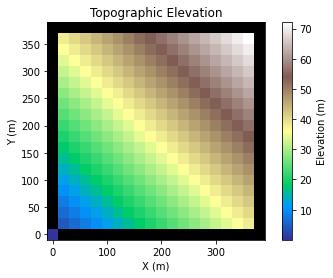

In [9]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

In [10]:
#Set elapsed time to zero
elapsed_time = 0

#Set timestep count to zero
count = 0

#Array to save sediment flux values and is currently filled with 0s
sed_flux = [0] * (run_time) 

space_img_interval = np.arange(10000, run_time, 10000)

#This will iterate through all of the years needed and will essentially run the model
while elapsed_time < run_time: #time units of years
    
    mg.at_node['bedrock__elevation'] += uplift_per_timestep  #adding uplift to the bedrock
    mg.at_node['topographic__elevation'] = mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth'] #changing the elevation to account for the uplift

    fa.run_one_step()
    sp.run_one_step(dt = timestep)
    #sed_flux[count] = mg.at_node["sediment__flux"][node_next_to_outlet]
    if elapsed_time in space_img_interval: #if you are at the correct interval to retrieve a photo from 
        print(elapsed_time)
        #Instantiate figure as empty plot
        fig = plt.figure()
        #Instantiate subplot as empty plot
        plot= plt.subplot()
        #Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
        imshow_grid(mg,"topographic__elevation", plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
        fig.savefig("fsc_topo_images/fsc_topo_" + str(elapsed_time) + ".png")
        plt.close()
    elapsed_time += timestep
    #print(count)

    #save the figure to separate folder and make sure to close each figure (saves on memory)
    '''
    if count in space_img_interval: #only produce image on the interval
        fig, (sed_plot, prof_plot, topo_plot) = plt.subplots(nrows = 3, sharex='none')


        #first make the channel profiler
        prf = ChannelProfiler(mg,number_of_watersheds=1, main_channel_only=True, minimum_channel_threshold=node_spacing**2)
        prf.run_one_step()

        prof_title_text = f"$K_{{sp}}$={.001}; $time$={elapsed_time} yr; $dx$={timestep} m"
        prof_plot = prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)', title=prof_title_text)
        
        #then make the sedimentograph
        sed_plot.plot(np.arange(run_time),sed_flux, color = 'k', linewidth = 3)
        sed_plot.set_title('Sedimentograph') #title
        sed_plot.set_xlabel('Time [yr]') #x axis label
        sed_plot.set_ylabel(r'Sediment flux [m$^3$/yr]') #y axis label

        #then make the topomap
        topo_plot = imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

        fig.savefig("all_images/all" + str(count) + ".png")'''

    #count +=1 #have this as the very last thing in loop
    #Instantiate figure as an empty plot
    #fig = plt.figure()

    #Instantiate subplot as an empty plot    
    #sedfluxplot = plt.subplot()

    #Creates the information in the graph with the runtim values from 0 to the end of the run_time , and the sed_flux array creates while the model was running
    #sedfluxplot.plot(np.arange(run_time),sed_flux, color = 'k', linewidth = 3)

    #Add axis labels to the plot 
    #sedfluxplot.set_title('Sedimentograph') #title
    #sedfluxplot.set_xlabel('Time [yr]') #x axis label
    #sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]') #y axis label

    #Instantiate subplot as empty plot
    #topoplot = plt.subplot
    #Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
    #imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

    #channel profiler
    

    #Show the profile
    #instantiate subplot as empty plot
    
    
    

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000


KeyboardInterrupt: 

In [ ]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)